In [4]:
import heapq
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class OrderBook:
    def __init__(self):
        # Use two heaps: max-heap for bids (store negative prices), min-heap for asks
        self.bids = []  # each entry: (-price, order_seq, quantity)
        self.asks = []  # each entry: (price, order_seq, quantity)
        self._order_seq = 0  # to track insertion order for FIFO

    def place_limit_order(self, side, price, quantity):
        """Place a limit order into the book."""
        self._order_seq += 1
        if side == 'buy':
            heapq.heappush(self.bids, (-price, self._order_seq, quantity))
        elif side == 'sell':
            heapq.heappush(self.asks, (price, self._order_seq, quantity))

    def place_market_order(self, side, quantity):
        """Execute a market order by matching against the opposite side of the book."""
        trades = []
        if side == 'buy':
            # Take from the lowest ask prices
            while quantity > 0 and self.asks:
                ask_price, ask_seq, ask_qty = heapq.heappop(self.asks)
                if ask_qty <= quantity:
                    # The market order eats this entire ask
                    trades.append((ask_price, ask_qty))
                    quantity -= ask_qty
                else:
                    # Partially fill the ask order
                    trades.append((ask_price, quantity))
                    remaining_qty = ask_qty - quantity
                    quantity = 0
                    # push the remaining part of ask back into the book
                    heapq.heappush(self.asks, (ask_price, ask_seq, remaining_qty))
            # If no asks, the market order goes unfilled (or partially filled).
        elif side == 'sell':
            # Take from the highest bid prices
            while quantity > 0 and self.bids:
                bid_price, bid_seq, bid_qty = heapq.heappop(self.bids)
                bid_price = -bid_price  # convert back to positive price
                if bid_qty <= quantity:
                    trades.append((bid_price, bid_qty))
                    quantity -= bid_qty
                else:
                    trades.append((bid_price, quantity))
                    remaining_qty = bid_qty - quantity
                    quantity = 0
                    heapq.heappush(self.bids, (-bid_price, bid_seq, remaining_qty))
        return trades  # list of (price, qty) trades executed

    def get_top_levels(self, depth=5):
        """Get the top 'depth' levels of bids and asks for reporting."""
        # Convert heaps to sorted lists (without mutating the heaps)
        best_bids = sorted([(-p, q) for (p, s, q) in self.bids], reverse=True)[:depth]
        best_asks = sorted([(p, q) for (p, s, q) in self.asks])[:depth]
        return best_bids, best_asks
    
    def get_cumulative_depth(self):
        bid_depth = []
        ask_depth = []
        
        total_bid_qty = 0
        for price, seq, qty in sorted(self.bids, reverse=True):
            price = -price
            total_bid_qty += qty
            bid_depth.append((price, total_bid_qty))
        
        total_ask_qty = 0
        for price, seq, qty in sorted(self.asks):
            total_ask_qty += qty
            ask_depth.append((price, total_ask_qty))
        
        return bid_depth, ask_depth

# Initialize the order book with some seed orders (to have a starting spread).
order_book = OrderBook()
order_book.place_limit_order('buy', price=100, quantity=10)   # best bid at 100
order_book.place_limit_order('sell', price=102, quantity=10)  # best ask at 102

# Simulation parameters
ticks = 252
random.seed(42)  # for reproducibility

mid_prices: list[float] = []

last_trade_price = None
for t in range(1, ticks+1):
    # Randomly decide market order buy or sell to simulate price movement
    if random.random() < 0.5:
        side = 'buy'
        qty = random.randint(1, 5)
    else:
        side = 'sell'
        qty = random.randint(1, 5)
    trades = order_book.place_market_order(side, qty)
    if trades:
        last_trade_price = trades[-1][0]  # price of the last trade executed
    # Have a simple agent place a new limit order on the opposite side to replenish liquidity
    if side == 'buy':
        # After a buy market order (price likely moved up), add a new sell order a few ticks above current price
        new_price = (last_trade_price or 102) + random.randint(1, 3)
        order_book.place_limit_order('sell', price=new_price, quantity=random.randint(1, 5))
    else:
        # After a sell market order (price likely moved down), add a new buy order a few ticks below current price
        new_price = (last_trade_price or 100) - random.randint(1, 3)
        if new_price < 1: new_price = 1
        order_book.place_limit_order('buy', price=new_price, quantity=random.randint(1, 5))
    # Gather top-of-book data for display
    best_bids, best_asks = order_book.get_top_levels(depth=3)
    best_bid = best_bids[0] if best_bids else None
    best_ask = best_asks[0] if best_asks else None

    if not (best_bid == None and best_ask == None):
        mid_prices.append((best_ask[0] + best_bid[0]) / 2)
    else:
        mid_prices.append(np.nan)


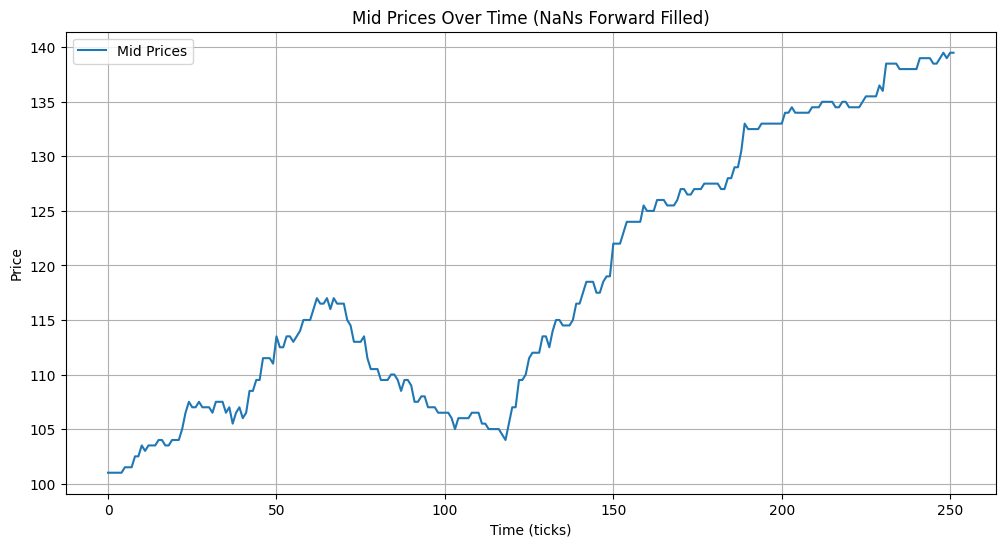

In [5]:
mid_prices_filled = np.where(np.isnan(mid_prices), np.nan, mid_prices)
for i in range(1, len(mid_prices_filled)):
    if np.isnan(mid_prices_filled[i]):
        mid_prices_filled[i] = mid_prices_filled[i - 1]

# Plot the mid_prices
plt.figure(figsize=(12, 6))
plt.plot(mid_prices_filled, label='Mid Prices', linestyle='-')
plt.xlabel('Time (ticks)')
plt.ylabel('Price')
plt.title('Mid Prices Over Time (NaNs Forward Filled)')
plt.legend()
plt.grid(True)
plt.show()